In [1]:
import sys
sys.path.append('../../')
import os
import dill

import numpy as np
import scipy as sc
import random as rand
from sklearn import preprocessing, linear_model
import matplotlib.pyplot as plt

from core.controllers import ConstantController

from koopman_core.dynamics import LinearLiftedDynamics, BilinearLiftedDynamics
from koopman_core.learning import Edmd_aut, KoopDnn
from koopman_core.systems import AutKoopSys

## Autonomous system with analytic finite dimensional Koopman operator

Consider the continuous-time dynamics

\begin{equation}
    \begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix}
    = \begin{bmatrix}
    \mu x_1\\
    -\lambda x_1^2 + \lambda x_2
    \end{bmatrix}
\end{equation}
by carefully choosing observables, the drift vector field of the dynamics can be reformulated as an equilvalent linear system (global linearization). Define the observables

\begin{equation}
\begin{bmatrix}
y_1 \\ y_2 \\ y_3
\end{bmatrix}
= \begin{bmatrix}
x_1 \\ x_2 \\ x_1^2
\end{bmatrix}
\end{equation}

then the system can be rewritten as

\begin{equation}
\begin{bmatrix}
\dot{y}_1 \\ \dot{y}_2 \\ \dot{y}_3 \end{bmatrix} = 
\begin{bmatrix}
\mu & 0 & 0\\
0 & \lambda & - \lambda \\
0 & 0 & \mu \end{bmatrix}
\begin{bmatrix}
y_1 \\ y_2 \\ y_3 \end{bmatrix}
\end{equation}




In [2]:
# System parameters
n, m = 2, 0
mu, lambd = -0.3, -0.6
system = AutKoopSys(mu, lambd)
sys_name = 'analytic_koop_sys'

### Collect data for learning

To collect data, a nominal controller is designed with LQR on the dynamics's linearization around hover. However, any
controller can be used and the method does not require the knowledge of model's linearization. In addition, a
exploratory white noise is added to the controller to ensure that the data is sufficiently excited. Note that the system
is underactuated and that trajectory optimization is necessary to control the position of the vehicle. We use a
simplified trajectory generator based on a model predictive controller for the linearized dynamics. More careful design
of the desired trajectory may be necessary for more demanding applications and this is readily compatible with our method.

4 data sets are collected to evaluate the impact of signal and process noise:
- Nominal data set (no signal or process noise)
- Data set with signal noise
- Data set with process noise
- Data set with signal and process noise

In [3]:
# Data collection parameters:
collect_data = True
dt = 5.0e-2                                                         # Time step length
traj_length_dc = 8.                                                 # Trajectory length, data collection
n_pred_dc = int(traj_length_dc/dt)                                  # Number of time steps, data collection
t_eval = dt * np.arange(n_pred_dc + 1)                              # Simulation time points
n_traj_train = 100                                                     # Number of trajectories to execute, data collection

xmax = np.array([1, 1])                                             # State constraints, trajectory generation
xmin = -xmax
x0_max = xmax                                                       # Initial value limits
sub_sample_rate = 1                                                 # Rate to subsample data for training
n_cols = 10                                                         # Number of columns in training data plot
folder_plots = 'figures/'                                           # Path to save plots
directory = os.path.abspath("")                                     # Path to save learned models

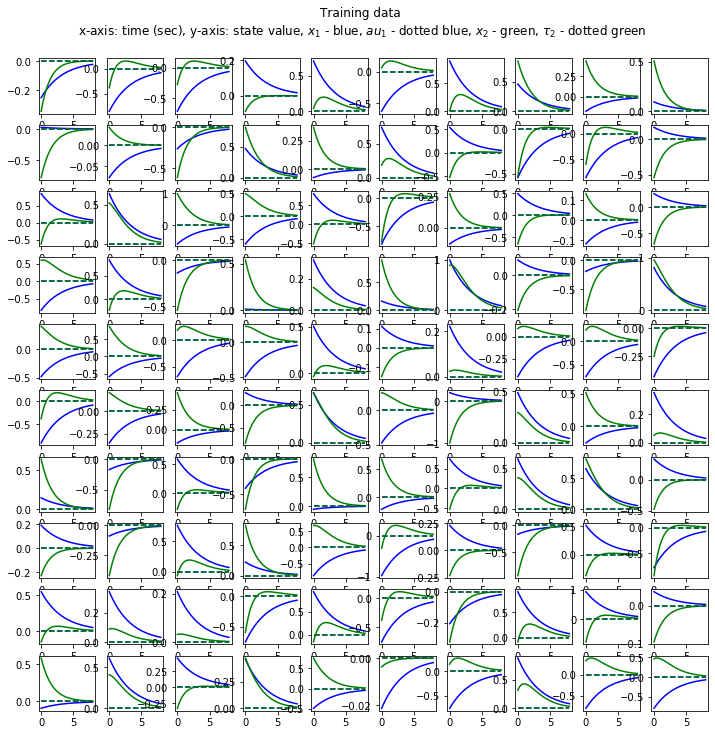

In [4]:
from koopman_core.util import run_experiment
if collect_data:
    xs, t_eval_train = run_experiment(system, n, n_traj_train, n_pred_dc, t_eval, x0_max, plot_experiment_data=True)

    data_list = [xs, t_eval, n_traj_train]
    outfile = open(directory + '/data/' + sys_name + '_data.pickle', 'wb')
    dill.dump(data_list, outfile)
    outfile.close()
else:
    infile = open(directory + '/data/' + sys_name + '_data.pickle', 'rb')
    xs, t_eval, n_traj_train, xs_test, t_eval_test, n_traj_test = dill.load(infile)
    infile.close()

### Learn a lifted linear model with Koopman DNN

In [5]:
net_params = {}
net_params['state_dim'] = n
net_params['encoder_hidden_dim'] = [10, 10]
net_params['encoder_output_dim'] = 4
net_params['optimizer'] = 'adam'
net_params['lr'] = 0.001
#net_params['momentum'] = 0.9
net_params['epochs'] = 20
net_params['batch_size'] = 16
net_params['lin_loss_penalty'] = 5e-1/net_params['encoder_output_dim']
net_params['l2_reg'] = 0
net_params['l1_reg'] = 0
net_params['n_multistep'] = 10
net_params['first_obs_const'] = False
net_params['override_kinematics'] = False
net_params['dt'] = dt

In [6]:
from koopman_core.learning import KoopmanNetAut

net = KoopmanNetAut(net_params)
model_koop_dnn = KoopDnn(net)
model_koop_dnn.set_datasets(xs, t_eval)
model_koop_dnn.model_pipeline(net_params, early_stop=True)
model_koop_dnn.construct_koopman_model()
sys_koop_dnn = LinearLiftedDynamics(model_koop_dnn.A, None, model_koop_dnn.C, model_koop_dnn.basis_encode, continuous_mdl=False, dt=dt)

Epoch   1: train loss: 0.00019949, validation loss: 0.00001898
Epoch   2: train loss: 0.00002006, validation loss: 0.00001845
Epoch   3: train loss: 0.00001982, validation loss: 0.00001831
Epoch   4: train loss: 0.00001979, validation loss: 0.00001843
Epoch   5: train loss: 0.00001978, validation loss: 0.00001872
Epoch   6: train loss: 0.00001988, validation loss: 0.00001850
Epoch   7: train loss: 0.00001985, validation loss: 0.00001900
Epoch   8: train loss: 0.00001993, validation loss: 0.00001827
Epoch   9: train loss: 0.00001556, validation loss: 0.00000118
Epoch  10: train loss: 0.00000065, validation loss: 0.00000035
Epoch  11: train loss: 0.00000039, validation loss: 0.00000030
Epoch  12: train loss: 0.00000036, validation loss: 0.00000027
Epoch  13: train loss: 0.00000034, validation loss: 0.00000026
Epoch  14: train loss: 0.00000032, validation loss: 0.00000026
Epoch  15: train loss: 0.00000031, validation loss: 0.00000030
Epoch  16: train loss: 0.00000028, validation loss: 0.0

### Learn a linear model with dynamic mode decomposition (DMD)

To compare our method with existing techniques, we first learn a linear state space model from data. This is dubbed dynamic mode decomposition. I.e. we use linear regression with LASSO regularization to learn an approximate linear model with model structure

\begin{equation}
    \mathbf{x}_{k+1} = A_{dmd} \mathbf{x}_k
\end{equation}


In [7]:
#DMD parameters:
alpha_dmd = 5.4e-4
tune_mdl_dmd = True

In [10]:
basis = lambda x: x
C_dmd = np.eye(n)

cv_dmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random')
standardizer_dmd = preprocessing.StandardScaler(with_mean=False)

optimizer_dmd = linear_model.MultiTaskLasso(alpha=alpha_dmd, fit_intercept=False, selection='random')
model_dmd = Edmd_aut(n, basis, n, n_traj_train, optimizer_dmd, cv=cv_dmd, standardizer=standardizer_dmd, C=C_dmd, first_obs_const=False, continuous_mdl=False, dt=dt)
X_dmd, y_dmd = model_dmd.process(xs, np.tile(t_eval,(n_traj_train,1)), downsample_rate=sub_sample_rate)
model_dmd.fit(X_dmd, y_dmd, cv=tune_mdl_dmd)
sys_dmd = LinearLiftedDynamics(model_dmd.A, None, model_dmd.C, model_dmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_dmd:
    print('$\\alpha$ DMD: ',model_dmd.cv.alpha_)

$\alpha$ DMD:  8.188597997428626e-06


### Learn a lifted linear model with extended dynamic mode decomposition (EDMD)

In addition, we compare our method with the current state of the art of Koopman based learning, the extended dynamic mode
decomposition. We use a dictionary of nonlinear functions $\boldsymbol{\phi(x)}$ to lift the state variables and learn a lifted state space model
of the dynamics. I.e. we first lift and then use linear regression with LASSO regularization to learn an approximate
lifted linear model with model structure

\begin{equation}
    \mathbf{z}_{k+1} = A_{edmd}\mathbf{z}_k, \qquad \mathbf{z} = \boldsymbol{\phi(x)}
\end{equation}

In [11]:
#EDMD parameters:
alpha_edmd = 1.2e-4
tune_mdl_edmd = True

In [14]:
koop_features = preprocessing.PolynomialFeatures(degree=2)
koop_features.fit(np.zeros((1,n)))
basis = lambda x: koop_features.transform(x)
n_lift_edmd = basis(np.zeros((1,n))).shape[1]

C_edmd = np.zeros((n,n_lift_edmd))
C_edmd[:,1:n+1] = np.eye(n)

optimizer_edmd = linear_model.MultiTaskLasso(alpha=alpha_edmd, fit_intercept=False, selection='random', max_iter=2000)
cv_edmd = linear_model.MultiTaskLassoCV(fit_intercept=False, n_jobs=-1, cv=3, selection='random', max_iter=2000)
standardizer_edmd = preprocessing.StandardScaler(with_mean=False)

model_edmd = Edmd_aut(n, basis, n_lift_edmd, n_traj_train, optimizer_edmd, cv=cv_edmd, standardizer=standardizer_edmd, C=C_edmd, continuous_mdl=False, dt=dt)
X_edmd, y_edmd = model_edmd.process(xs, np.tile(t_eval,(n_traj_train,1)), downsample_rate=sub_sample_rate)
model_edmd.fit(X_edmd, y_edmd, cv=tune_mdl_edmd)
sys_edmd = LinearLiftedDynamics(model_edmd.A, None, model_edmd.C, model_edmd.basis, continuous_mdl=False, dt=dt)
if tune_mdl_edmd:
    print('$\\alpha$ EDMD: ', model_edmd.cv.alpha_)

$\alpha$ EDMD:  7.419977843567898e-05


### Evaluate open loop prediction performance

We now evaluate the open loop prediction performance of the implemented methods.
This is done by generating a new data set in the same way as the training set, predicting the evolution of the system
with the control sequence of each trajectory executed in the data set with each of the models, and finally comparing
the mean and standard deviation of the error between the true and predicted evolution over the trajectories. All the models are evaluated on 2 test data sets. One nominal data set (no signal or process noise) and a data set with process noise. No test data with signal noise is used, as we would need to fix the signal noise sequence to do a fair comparison in open loop prediction, hence resulting in the same comparison as the 2 data sets used.

In [16]:
# Prediction performance evaluation parameters:
n_traj_ol = n_traj_train                                                     # Number of trajectories to execute, open loop

In [19]:
from tabulate import tabulate

t_eval = dt * np.arange(4./dt + 1)
xs_ol = np.empty((n_traj_ol, t_eval.shape[0], n))    
xs_koop_dnn_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_dmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
xs_edmd_ol = np.empty((n_traj_ol, t_eval.shape[0]-1, n))
ctrl = ConstantController(system, 0.)
    
for ii in range(n_traj_ol):
    x0 = np.asarray([rand.uniform(l, u) for l, u in zip(-x0_max, x0_max)])
    xs_ol[ii,:,:], _ = system.simulate(x0, ctrl, t_eval)

    z_0_koop_dnn = sys_koop_dnn.basis(np.atleast_2d(x0)).squeeze()
    zs_koop_dnn_tmp, _ = sys_koop_dnn.simulate(z_0_koop_dnn, ctrl, t_eval[:-1])
    xs_koop_dnn_ol[ii,:,:] = np.dot(sys_koop_dnn.C, zs_koop_dnn_tmp.T).T
    
    xs_dmd_ol[ii,:,:], _ = sys_dmd.simulate(x0, ctrl, t_eval[:-1])

    z_0_edmd = sys_edmd.basis(np.atleast_2d(x0)).squeeze()
    zs_edmd_tmp, _ = sys_edmd.simulate(z_0_edmd, ctrl, t_eval[:-1])
    xs_edmd_ol[ii,:,:] = np.dot(sys_edmd.C, zs_edmd_tmp.T).T

data = [xs_koop_dnn_ol, xs_dmd_ol, xs_edmd_ol]
mdl_names = ['Koopman DNN', 'DMD', 'EDMD']
error, mse, std = [], [], []

for ii, d in enumerate(data):
    err_tmp = xs_ol[:,:-1,:]-d
    error.append(err_tmp)
    mse.append(np.mean(np.square(error[ii])))
    std.append(np.std(error[ii]))
    
print('\nOpen loop performance statistics:')

table_data = []
for name, mse_mdl, std_mdl in zip(mdl_names, mse, std):
    table_data.append([name, "{:.5f}".format(mse_mdl), "{:.5f}".format(std_mdl)])

print(tabulate(table_data, 
               headers=['Mean squared error', 'Standard deviation']))


Open loop performance statistics:
               Mean squared error    Standard deviation
-----------  --------------------  --------------------
Koopman DNN               0.00183               0.0414
DMD                       0.00988               0.0874
EDMD                      1e-05                 0.00327


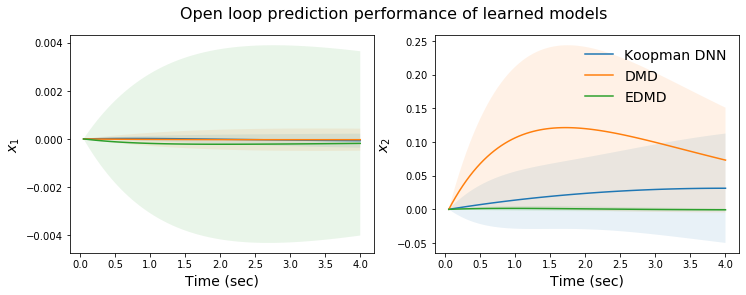

In [20]:
import matplotlib.pyplot as plt
import matplotlib

figwidth = 12
lw = 2
fs = 14
y_lim_gain = 1.2
row = 1
col = 2

#Plot open loop results:
plt.figure(figsize=(figwidth,4))
axs = [plt.subplot(row,col,jj+1) for jj in range(n)]

for ii, err in enumerate(error):
    err_mean = np.mean(err, axis=0)
    err_std = np.std(err, axis=0)
    
    for jj in range(n):
        axs[jj].plot(t_eval[1:], err_mean[:,jj], label=mdl_names[ii])
        axs[jj].fill_between(t_eval[1:], err_mean[:,jj]-err_std[:,jj], err_mean[:,jj]+err_std[:,jj], alpha=0.1)

for jj in range(n):
    axs[jj].set_xlabel('Time (sec)', fontsize=fs)
    axs[jj].set_ylabel('$x_'+ str(jj+1) + '$', fontsize=fs)

plt.legend(frameon=False, fontsize=fs)
stitle=plt.suptitle('Open loop prediction performance of learned models', fontsize=fs+2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.savefig(folder_plots + 'koop_sys_prediction.pdf', format='pdf', dpi=2400, bbox_extra_artists=(stitle,), bbox_inches="tight")
plt.show()

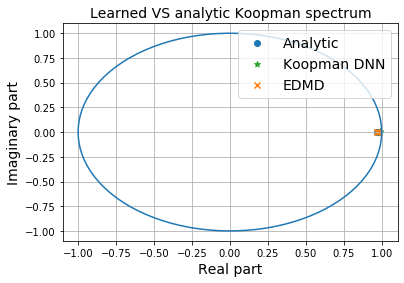

In [21]:
analytic_koop = sc.linalg.expm(np.array([[mu, 0, 0], [0, lambd, -lambd], [0, 0, mu]])*dt)
eig_analytic = np.linalg.eigvals(analytic_koop)
eig_koop_dnn = np.sort(np.linalg.eigvals(sys_koop_dnn.A))[::-1]
eig_edmd = np.sort(np.linalg.eigvals(sys_edmd.A))[::-1]
n_eig = eig_analytic.size
eig_koop_dnn = eig_koop_dnn[:n_eig]
eig_edmd = eig_edmd[:n_eig]
ang = np.linspace(0,2*np.pi,100)
circle = np.array([np.cos(ang), np.sin(ang)])

plt.figure()
plt.plot(circle[0,:], circle[1,:])
plt.scatter(np.real(eig_analytic), np.imag(eig_analytic), marker='o', color='tab:blue', label='Analytic')
plt.scatter(np.real(eig_koop_dnn), np.imag(eig_koop_dnn), marker='*', color='tab:green', label='Koopman DNN')
plt.scatter(np.real(eig_edmd), np.imag(eig_edmd), marker='x', color='tab:orange', label='EDMD')
plt.legend(loc='upper right', fontsize=fs)
plt.grid()
plt.title('Learned VS analytic Koopman spectrum', fontsize=fs)
plt.xlabel('Real part', fontsize=fs)
plt.ylabel('Imaginary part', fontsize=fs)
plt.show()